#### Download data, label, code

In [1]:
!pip install --upgrade gdown
!gdown --fuzzy 1xQzhuXy4DE17OR3qKBxlBQQm8K3qsT0z
!gdown --fuzzy 1BOyupz4UtMvp7r1VuwzpkUfSsBgUJEdj
!gdown --fuzzy 1bc1T94cAEqGl4N2cuJ2fGZFkXDUWhl27

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1xQzhuXy4DE17OR3qKBxlBQQm8K3qsT0z
To: /content/physionet2017npy.zip
100% 98.4M/98.4M [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BOyupz4UtMvp7r1VuwzpkUfSsBgUJEdj
To: /content/train.csv
100% 61.4k/61.4k [00:00<00:00, 53.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bc1T94cAEqGl4N2cuJ2fGZFkXDUWhl27
To: /content/val.csv
100% 15.4k/15.4k [00:00<00:00, 18.1MB/s]


In [2]:
!unzip -q physionet2017npy.zip

In [3]:
# download code
!git clone https://github.com/taipingeric/physiolu.git

Cloning into 'physiolu'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [4]:
!pip install einops
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 218 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 25.0 MB/s 
     |████████████████████████████████| 182 kB 66.6 MB/s 


In [5]:
import sys
sys.path.append("./physiolu")

In [6]:
import torch
import torch.nn as nn
import torchsummary

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix, f1_score
from sklearn.utils import resample, shuffle

from utils import DiceLoss, IoULoss
from modelcls import ResNet1DEncoder, ET
from aug import random_aug
from utils import evaluation
from convnext import ConvNeXt
import config
# from dataset import *

fine tune:  True
Freeze encoder:  False
Augmentation True
Class weight:  True
Banlanc class:  True
model :  convnext
SSL :  simclr
device:  cuda


In [7]:
device = config.device

In [8]:
class PhysioClsDataset(torch.utils.data.Dataset):
    def __init__(self, training, csv_path, sig_dir, config, aug=False, sample_size=512):
        super().__init__()
        self.training = training
        self.sample_size = sample_size
        self.sig_dir = sig_dir
        self.aug = aug
        self.cls_names = config.CLASS_NAMES # ['N', 'O', 'A', '~']
        self.cls_map = {n: i for i, n in enumerate(self.cls_names)}
        self.df = pd.read_csv(csv_path).iloc[:, :]
#         self.df_raw = self.df.copy()
        self.df = self.df[self.df['cls'].isin(self.cls_names)]
        # balance sample
        if config.BALANCE_CLASS and self.training:
            df_N = self.df[self.df['cls']=='N']
            df_O = self.df[self.df['cls']=='O']
            df_A = self.df[self.df['cls']=='A']
            max_count = len(df_N)
            print('max_count:' , max_count)
            df_O = resample(df_O, random_state=5566, n_samples=max_count, replace=True)
            df_A = resample(df_A, random_state=5566, n_samples=max_count, replace=True)
            self.df = pd.concat([df_N, df_O, df_A])
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df_pat = self.df.iloc[idx, :]
        pat_id = df_pat[0]
        label = df_pat[1]
        filename = f'{pat_id}_{label}.npy'
        sig = np.load(f'{self.sig_dir}{filename}')
        sig_len = len(sig)
        if sig_len > self.sample_size:
            start_idx = np.random.randint(0, sig_len - self.sample_size)
            sig = sig[start_idx: start_idx+self.sample_size]
        else:
            sig = np.pad(sig, pad_width=(0, self.sample_size-sig_len), constant_values=(0,))
        sig = sig[np.newaxis, ::]
        if self.aug:
            sig = random_aug(sig)
        # Normalization
        sig = (sig-sig.mean()) / sig.std()
        # Tensor
        label = self.cls_map[label]
        label = torch.tensor(label, dtype=torch.int64)
        sig = torch.tensor(sig, dtype=torch.float)
        return sig, label
    
train_ds = PhysioClsDataset(training=True,
                            csv_path='./train.csv', 
                            sig_dir='./npy/',
                            config=config,
                            sample_size=300*30,
                            aug=config.AUG)
val_ds = PhysioClsDataset(training=False,
                          csv_path='./val.csv', 
                          sig_dir='./npy/',
                          config=config,
                          sample_size=300*30,
                          aug=False)

train_loader = torch.utils.data.DataLoader(train_ds, config.BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, config.BS)
len(train_ds), len(val_ds)

max_count: 4087


(12261, 1646)

In [9]:
df = pd.read_csv('./train.csv')
df.cls.value_counts()

N    4087
O    1908
A     608
~     219
Name: cls, dtype: int64

In [10]:
print(np.unique(train_ds.df['cls'], return_counts=True)) #, np.unique(train_ds.df_raw['cls'], return_counts=True)
print(np.unique(val_ds.df['cls'], return_counts=True))

(array(['A', 'N', 'O'], dtype=object), array([4087, 4087, 4087]))
(array(['A', 'N', 'O'], dtype=object), array([150, 989, 507]))


#### Training

In [11]:
config.FINE_TUNE = False
config.FREEZE = False

In [12]:
# https://github.com/hsd1503/resnet1d/blob/5825e86b033a4381e0e320fe4052e09b27b39b98/test_synthetic.py
# (n_block, downsample_gap, increasefilter_gap) = (8, 1, 2)
    # 34 layer (16*2+2): 16, 2, 4
    # 98 layer (48*2+2): 48, 6, 12
def build_model():
    if config.MODELTYPE == "cnn":
        encoder = ResNet1DEncoder(
        in_channels=config.N_CHANNEL, 
        base_filters=config.base_filters, 
        kernel_size=config.kernel_size, 
        stride=config.stride, 
        n_block=config.n_block, 
        downsample_gap=config.downsample_gap, 
        increasefilter_gap=config.increasefilter_gap,
        groups=config.groups,
        verbose=config.verbose)
#         encoder = ResNet1DEncoder(
#             in_channels=config.N_CHANNEL, 
#             base_filters=config.base_filters, 
#             kernel_size=config.kernel_size, 
#             stride=config.stride, 
#             n_block=config.n_block, 
#             downsample_gap=config.downsample_gap, 
#             increasefilter_gap=config.increasefilter_gap,
#             groups=config.groups,
#             verbose=False)
        classifier = nn.Sequential(
            nn.Linear(512, config.NUM_CLS),
        )
    elif config.MODELTYPE == "transformer":
        encoder = ET(
                    sig_size = config.SIG_LEN,
                    channels=config.N_CHANNEL,
                    patch_size = config.patch_size,
                    dim = config.dim,
                    depth = config.depth,
                    heads = config.heads,
                    mlp_dim = config.mlp_dim,
                    dropout = config.dropout,
                    emb_dropout = config.emb_dropout,
                    pool=config.pool)
        classifier = nn.Sequential(
            nn.LayerNorm(config.dim),
            nn.Linear(config.dim, config.NUM_LABEL),
            nn.Sigmoid()
        )
    elif config.MODELTYPE == 'convnext':
        encoder = ConvNeXt(depths=config.depths, dims=config.dims, config=config)
        if config.DROP_OUT == 0.:
            classifier = nn.Sequential(nn.Linear(config.dims[-1], config.NUM_CLS))
        else:
            classifier = nn.Sequential(nn.Dropout(config.DROP_OUT), nn.Linear(config.dims[-1], config.NUM_CLS))
    else:
        raise AssertionError('wrong model type')
                

    model = nn.Sequential(encoder, classifier)
    
    
    if config.FINE_TUNE:
        encoder_path = os.path.join(config.default_root_dir, config.MODEL_NAME)
#         encoder.load_state_dict(torch.load(encoder_path))
# 100000encoder-simclr-convnext.pth
        encoder.load_state_dict(torch.load('../../../Documents/ntuecg/physiosslmodel/backup/simclr512-2017-pbt/encoder-simclr-convnext.pth'))
        print('load encoder :', encoder_path)
        
    if config.FREEZE:
        for param in encoder.parameters():
            param.requires_grad = False
        
    return model

# def build_model():
#     encoder = ResNet1DEncoder(
#         in_channels=N_CHANNEL, 
#         base_filters=64, 
#         kernel_size=16, 
#         stride=2, 
#         n_block=16, 
#         downsample_gap=2, 
#         increasefilter_gap=4,
#         groups=32,
#         verbose=False)
#     classifier = nn.Sequential(*[
#         nn.Linear(512, 20),
#         nn.Sigmoid()
#     ])
    
#     model = nn.Sequential(*[
#         encoder,
#         classifier
#     ])
#     encoder.load_state_dict(torch.load('encoder.pth'))
#     # freeze 
#     for param in encoder.parameters():
#         param.requires_grad = False
#     return model

In [15]:
model = build_model().to(device)

In [16]:
# Summary
torchsummary.summary(model, (1, 9000), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 692]             448
       ChannelPool-2               [-1, 2, 692]               0
        CBAMConv1d-3               [-1, 1, 692]              14
       BatchNorm1d-4               [-1, 1, 692]               2
         BasicConv-5               [-1, 1, 692]               0
       SpatialGate-6              [-1, 32, 692]               0
         LayerNorm-7              [-1, 32, 692]              64
            Conv1d-8              [-1, 32, 692]             256
         LayerNorm-9              [-1, 692, 32]              64
           Linear-10             [-1, 692, 128]           4,224
             GELU-11             [-1, 692, 128]               0
           Linear-12              [-1, 692, 32]           4,128
AdaptiveAvgPool1d-13                [-1, 32, 1]               0
           Linear-14                   

In [17]:
# print(model)
config.VERBOSE

True

In [18]:
# Average binary accuracy for all pixel in a batch
def get_accuracy(y_true, y_prob):
    return (y_true == y_prob).sum().item() / y_true.nelement()

def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False, disable=not config.VERBOSE)):
        x, y = x.to(device), y.to(device) # move data to GPU
        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)
        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params
        # log
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # return avg loss of epoch, avg acc of epoch
    return epoch_loss/num_batches, epoch_correct/size
    

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0
    
    y_pred = np.empty((0, 3))
    y_true = np.array([])
    
    # No training for test data
    with torch.no_grad():
#     with torch.autograd.detect_anomaly():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)
            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # F1 Score
            y_pred = np.concatenate((y_pred, pred.cpu().detach().numpy()))
            y_true = np.concatenate((y_true, y.cpu().detach().numpy()))
    y_pred = np.argmax(np.array(y_pred), axis=-1)
    f1 = f1_score(y_true, y_pred, average='macro')
        
    return epoch_loss/num_batches, epoch_correct / size, f1

In [19]:
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
}
def train(loss_fn, epochs=100, save=True, model_path='model-cls.pth'):
    # Model
    model = build_model().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    EPOCHS = epochs
    
    best_loss = np.inf
    best_f1 = 0.
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc, val_f1 = test_epoch(val_loader, model, loss_fn)
        
        if config.VERBOSE:
            print(f'EPOCH: {epoch:04d} \
 train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
 val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}, val_f1: {val_f1:.3f}')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)
        
        if val_loss < best_loss:
            
            best_loss = val_loss
        if val_f1 > best_f1:
            print('Save model')
            torch.save(model.state_dict(), model_path)
            best_f1 = val_f1

    # plot result
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()

In [20]:
EPOCHS = 2 # 10
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(config.CLASS_WEIGHT, 
                                                  dtype=torch.float).to(device) if config.USE_CLASS_WEIGHT else None)

max_count: 4087


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

EPOCH: 0000  train_loss: 0.8616, train_acc: 0.335  val_loss: 1.4979, val_acc: 0.091, val_f1: 0.056
Save model


  0%|          | 0/192 [00:00<?, ?it/s]

EPOCH: 0001  train_loss: 0.8285, train_acc: 0.333  val_loss: 1.3518, val_acc: 0.091, val_f1: 0.056


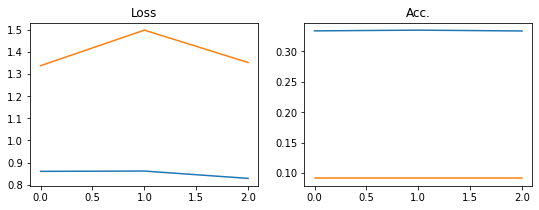

FileNotFoundError: ignored

In [22]:
# Basic Train
train_ds = PhysioClsDataset(training=True,
                            csv_path='./train.csv', 
                            sig_dir='./npy/',
                            config=config,
                            sample_size=300*30,
                            aug=config.AUG)
val_ds = PhysioClsDataset(training=False,
                          csv_path='./val.csv', 
                          sig_dir='./npy/',
                          config=config,
                          sample_size=300*30,
                          aug=False)

train_loader = torch.utils.data.DataLoader(train_ds, config.BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, config.BS)
len(train_ds), len(val_ds)

train(loss_fn=loss_fn, 
        epochs=EPOCHS, 
        model_path="best.pth", 
        save=True)


In [23]:
# restore weights
weight_path = config.MODEL_PATH
model = build_model().to(device)
model.load_state_dict(torch.load("best.pth"))
evaluation(model, val_loader, device)

  0%|          | 0/26 [00:00<?, ?it/s]

(1646,) (1646,)
0.055679287305122505
              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       989
         1.0      0.000     0.000     0.000       507
         2.0      0.091     1.000     0.167       150

    accuracy                          0.091      1646
   macro avg      0.030     0.333     0.056      1646
weighted avg      0.008     0.091     0.015      1646



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
